(time-cont-scale-notebook)=
# Il tempo su una metrica continua

Quando si affronta lo studio del cambiamento in un individuo, un aspetto cruciale è la selezione di una scala temporale adeguata per osservare questo cambiamento. Nel capitolo precedente, ad esempio, abbiamo adottato il grado scolastico come nostra scala temporale di riferimento, strutturando le osservazioni su questa base. Tuttavia, il grado scolastico non è l'unica scala temporale applicabile a tali dati. Altre scale significative potrebbero essere l'età o le specifiche occasioni in cui si effettuano le misurazioni. 

Ci sono scale temporali che rappresentano intervalli discreti, come le occasioni di misurazione, dove i valori assunti sono specifici e comuni tra i partecipanti. In questo contesto, però, potrebbe non essere possibile valutare ogni partecipante ad ogni occasione di misurazione. D'altra parte, esistono scale temporali più fluide, come l'età, dove i valori sono unici per ciascun partecipante e non condivisi. 

Interessante è notare come la stessa scala temporale possa essere impiegata sia in un contesto discreto che continuo. Ad esempio, l'età può essere approssimata all'anno più vicino, mentre il grado scolastico può essere definito più precisamente, considerando l'anno scolastico e il numero di giorni trascorsi dall'inizio dell'anno scolastico.

In questo capitolo, ci concentreremo sulle tecniche per modellare la crescita individuale utilizzando una scala temporale continua, esplorando come questa possa fornire una comprensione più dettagliata e sfumata del cambiamento all'interno della persona.

In [1]:
source("../_common.R")
suppressPackageStartupMessages({
    library("DT")
    library("kableExtra")
    library("lme4")
})

## L'Applicazione della Finestra Temporale

Proseguendo nell'analisi delle metriche del tempo, un approccio interessante è quello della finestra temporale, particolarmente utile per dati che presentano occasioni di misurazione variabili individualmente. Questa metodologia cerca di standardizzare la variabilità temporale individuale su una scala temporale discreta. Un esempio pratico di questo può essere visto nell'arrotondamento dell'età o del tempo al semestre o al quarto d'anno più vicino.

Questo metodo, benché utile, rappresenta ancora un'approssimazione della realtà temporale. Riducendo la dimensione delle finestre temporali si può aumentare la precisione, ma questo può comportare una maggiore dispersione dei dati, rendendo così più complessa l'accuratezza delle stime.

Nell'applicazione pratica di questo esempio, definiamo le finestre temporali in termini di semestri. Pertanto, lavoriamo con i dati in formato long, arrotondando l'età al semestre più vicino, e successivamente convertiamo questi dati in formato wide. Questo consente la loro integrazione nel framework SEM, facilitando l'analisi e l'interpretazione dei cambiamenti individuali nel tempo.

Per questo esempio considereremo i dati di abilità matematica NLSY-CYA Long Data [si veda {cite:t}`grimm2016growth`]. Iniziamo a leggere i dati.

In [2]:
#set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_long_R.dat"
#read in the text data file using the url() function
dat <- read.table(file=url(filepath),
                  na.strings = ".")  #indicates the missing data designator
#copy data with new name 
nlsy_math_long <- dat  

#Add names the columns of the data set
names(nlsy_math_long) = c('id'     , 'female', 'lb_wght', 
                          'anti_k1', 'math'  , 'grade'  ,
                          'occ'    , 'age'   , 'men'    ,
                          'spring' , 'anti')

#subset to the variables of interest
nlsy_math_long <- nlsy_math_long[ ,c("id", "math", "grade", "age")]
#view the first few observations in the data set 
head(nlsy_math_long, 10)

,id,math,grade,age
,<int>,<int>,<int>,<int>
1,201,38,3,111
2,201,55,5,135
3,303,26,2,121
4,303,33,5,145
5,2702,56,2,100
6,2702,58,4,125
7,2702,80,8,173
8,4303,41,3,115
9,4303,58,4,135


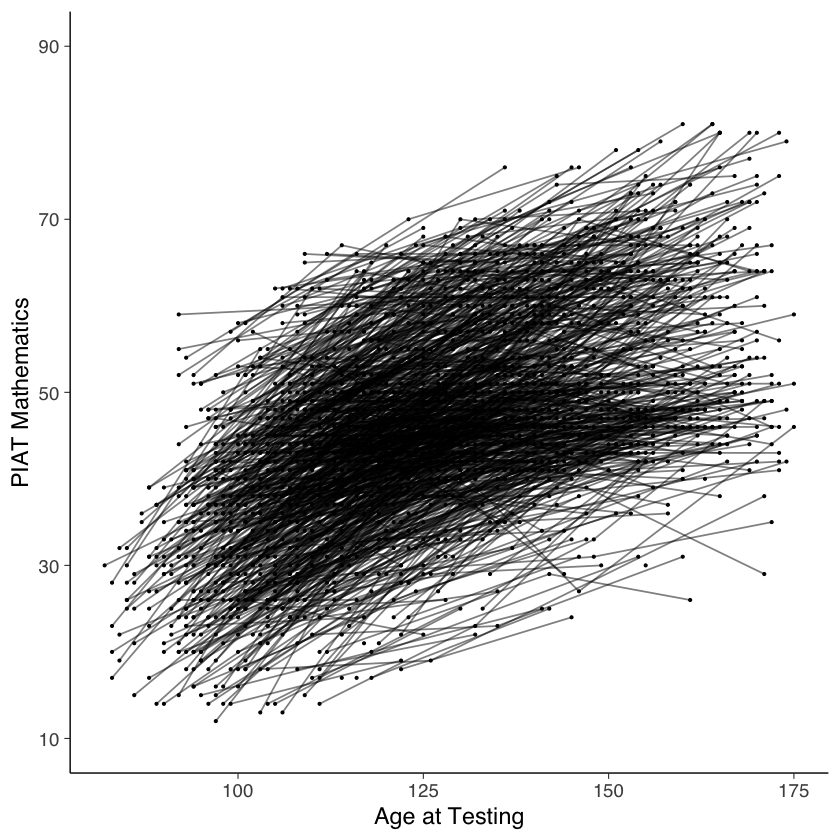

In [3]:
#intraindividual change trajetories
ggplot(data=nlsy_math_long,                    #data set
       aes(x = age, y = math, group = id)) + #setting variables
  geom_point(size=.5) + #adding points to plot
  geom_line(alpha = 0.5) +  #adding lines to plot
  #setting the x-axis with breaks and labels
  scale_x_continuous(#limits=c(2,8),
                     #breaks = c(2,3,4,5,6,7,8), 
                     name = "Age at Testing") +    
  #setting the y-axis with limits breaks and labels
  scale_y_continuous(limits=c(10,90), 
                     breaks = c(10,30,50,70,90), 
                     name = "PIAT Mathematics")

 Implementiamo il metodo della finestra temporale e ricodifichiamo i dati in formato wide.

In [4]:
# creating new age variable scaled in years
nlsy_math_long$ageyr <- (nlsy_math_long$age / 12)
head(nlsy_math_long)

,id,math,grade,age,ageyr
,<int>,<int>,<int>,<int>,<dbl>
1,201,38,3,111,9.250000
2,201,55,5,135,11.250000
3,303,26,2,121,10.083333
4,303,33,5,145,12.083333
5,2702,56,2,100,8.333333
6,2702,58,4,125,10.416667


In [5]:
# rounding to nearest half-year
# multiplied by 10 to remove decimal for easy conversion to wide
nlsy_math_long$agewindow <- plyr::round_any(nlsy_math_long$ageyr * 10, 5)
head(nlsy_math_long)

,id,math,grade,age,ageyr,agewindow
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,201,38,3,111,9.250000,90
2,201,55,5,135,11.250000,110
3,303,26,2,121,10.083333,100
4,303,33,5,145,12.083333,120
5,2702,56,2,100,8.333333,85
6,2702,58,4,125,10.416667,105


In [6]:
# reshaping long to wide (just variables of interest)
nlsy_math_wide <- reshape(
  data = nlsy_math_long[, c("id", "math", "agewindow")],
  timevar = c("agewindow"),
  idvar = c("id"),
  v.names = c("math"),
  direction = "wide", sep = ""
)

# reordering columns for easy viewing
nlsy_math_wide <- nlsy_math_wide[, c(
  "id", "math70", "math75", "math80", "math85", "math90", "math95", "math100", "math105", "math110", "math115", "math120", "math125", "math130", "math135", "math140", "math145"
)]
# looking at the data
head(nlsy_math_wide)

,id,math70,math75,math80,math85,math90,math95,math100,math105,math110,math115,math120,math125,math130,math135,math140,math145
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,NA,NA,NA,NA,38,NA,NA,NA,55,NA,NA,NA,NA,NA,NA,NA
3,303,NA,NA,NA,NA,NA,NA,26,NA,NA,NA,33,NA,NA,NA,NA,NA
5,2702,NA,NA,NA,56,NA,NA,NA,58,NA,NA,NA,NA,NA,NA,NA,80
8,4303,NA,NA,NA,NA,NA,41,NA,NA,58,NA,NA,NA,NA,NA,NA,NA
10,5002,NA,NA,NA,NA,NA,NA,46,NA,NA,NA,54,NA,NA,NA,66,NA
13,5005,NA,NA,35,NA,NA,50,NA,NA,NA,60,NA,NA,NA,59,NA,NA


Specifichiamo il modello SEM.

In [7]:
lg_math_age_lavaan_model <- '
  # latent variable definitions
      #intercept (note intercept is a reserved term)
      eta_1 =~  1*math70 +
                1*math75 +
                1*math80 +
                1*math85 +
                1*math90 +
                1*math95 +
                1*math100 +
                1*math105 +
                1*math110 +
                1*math115 +
                1*math120 +
                1*math125 +
                1*math130 +
                1*math135 +
                1*math140 +
                1*math145 

      #linear slope (note intercept is a reserved term)
      eta_2 =~ -1*math70 +
               -0.5*math75 +
                0*math80 +
                0.5*math85 +
                1*math90 +
                1.5*math95 +
                2*math100 +
                2.5*math105 +
                3*math110 +
                3.5*math115 +
                4*math120 +
                4.5*math125 +
                5*math130 +
                5.5*math135 +
                6*math140 +
                6.5*math145

  # factor variances
      eta_1 ~~ start(65)*eta_1
      eta_2 ~~ start(.75)*eta_2

  # covariances among factors 
      eta_1 ~~ start(1.2)*eta_2

  # manifest variances (made equivalent by naming theta)
      math70 ~~ start(35)*theta*math70
      math75 ~~ theta*math75
      math80 ~~ theta*math80
      math85 ~~ theta*math85
      math90 ~~ theta*math90
      math95 ~~ theta*math95
      math100 ~~ theta*math100
      math105 ~~ theta*math105
      math110 ~~ theta*math110
      math115 ~~ theta*math115
      math120 ~~ theta*math120
      math125 ~~ theta*math125
      math130 ~~ theta*math130
      math135 ~~ theta*math135
      math140 ~~ theta*math140
      math145 ~~ theta*math145
      
  # manifest means (fixed at zero)
      math70 ~ 0*1
      math75 ~ 0*1
      math80 ~ 0*1
      math85 ~ 0*1
      math90 ~ 0*1
      math95 ~ 0*1
      math100 ~ 0*1
      math105 ~ 0*1
      math110 ~ 0*1
      math115 ~ 0*1
      math120 ~ 0*1
      math125 ~ 0*1
      math130 ~ 0*1
      math135 ~ 0*1
      math140 ~ 0*1
      math145 ~ 0*1

  # factor means (estimated freely)
      eta_1 ~ start(35)*1
      eta_2 ~ start(4)*1
' #end of model definition

In questo modello, si definiscono due variabili latenti: l'intercetta latente (`eta_1`) e la pendenza lineare (`eta_2`). La scelta dei coefficienti per `eta_2` consente di modellare una traiettoria di crescita lineare nel tempo. Ogni coefficiente corrisponde al peso assegnato a ciascuna misura di matematica (`math70`, `math75`, ..., `math145`) nell'espressione della pendenza lineare. 

- I coefficienti vanno da `-1` a `6.5`, aumentando di `0.5` ad ogni passaggio. Questa progressione rappresenta l'aumento lineare nel tempo. Ad esempio, `math70` ha un coefficiente di `-1`, `math75` ha un coefficiente di `-0.5`, e così via fino a `math145`, che ha un coefficiente di `6.5`.
- I coefficienti sono scelti per mantenere una distanza temporale costante tra ogni punto di misurazione. Ad esempio, la differenza di `0.5` tra i coefficienti di `math70` e `math75` implica che il lasso di tempo tra queste due misurazioni è costante rispetto alle altre misurazioni.
- È interessante notare che il coefficiente per `math80` è `0`. Questo implica che `math80` è stato scelto come punto di riferimento o centro per la pendenza lineare. I valori negativi e positivi dei coefficienti rappresentano misurazioni prima e dopo questo punto di riferimento, rispettivamente.

Adattiamo il modello ai dati.

In [8]:
#estimating the model using sem() function
lg_math_age_lavaan_fit <- sem(lg_math_age_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have 0%
    coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo la soluzione.

In [9]:
summary(lg_math_age_lavaan_fit, fit.measures = TRUE) |>
    print()

Warning message in pchisq(X2, df = df, ncp = ncp):
“Si è prodotto un NaN”


Warning message in pchisq(X2, df = df, ncp = ncp):
“Si è prodotto un NaN”


lavaan 0.6.17 ended normally after 27 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        21
  Number of equality constraints                    15

  Number of observations                           932
  Number of missing patterns                       139

Model Test User Model:
                                                      
  Test statistic                               295.028
  Degrees of freedom                               146
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                              1053.342
  Degrees of freedom                               120
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.840
  Tucker-Lewis Index (TLI)                       0.869
                                   

In [10]:
parameterEstimates(lg_math_age_lavaan_fit) |>
    print()

       lhs op     rhs label    est    se       z pvalue ci.lower ci.upper
1    eta_1 =~  math70        1.000 0.000      NA     NA    1.000    1.000
2    eta_1 =~  math75        1.000 0.000      NA     NA    1.000    1.000
3    eta_1 =~  math80        1.000 0.000      NA     NA    1.000    1.000
4    eta_1 =~  math85        1.000 0.000      NA     NA    1.000    1.000
5    eta_1 =~  math90        1.000 0.000      NA     NA    1.000    1.000
6    eta_1 =~  math95        1.000 0.000      NA     NA    1.000    1.000
7    eta_1 =~ math100        1.000 0.000      NA     NA    1.000    1.000
8    eta_1 =~ math105        1.000 0.000      NA     NA    1.000    1.000
9    eta_1 =~ math110        1.000 0.000      NA     NA    1.000    1.000
10   eta_1 =~ math115        1.000 0.000      NA     NA    1.000    1.000
11   eta_1 =~ math120        1.000 0.000      NA     NA    1.000    1.000
12   eta_1 =~ math125        1.000 0.000      NA     NA    1.000    1.000
13   eta_1 =~ math130        1.000 0.0

In [11]:
inspect(lg_math_age_lavaan_fit, what="est") |>
    print()

$lambda
        eta_1 eta_2
math70      1  -1.0
math75      1  -0.5
math80      1   0.0
math85      1   0.5
math90      1   1.0
math95      1   1.5
math100     1   2.0
math105     1   2.5
math110     1   3.0
math115     1   3.5
math120     1   4.0
math125     1   4.5
math130     1   5.0
math135     1   5.5
math140     1   6.0
math145     1   6.5

$theta
        math70 math75 math80 math85 math90 math95 mth100 mth105 mth110 mth115
math70  32.337                                                               
math75   0.000 32.337                                                        
math80   0.000  0.000 32.337                                                 
math85   0.000  0.000  0.000 32.337                                          
math90   0.000  0.000  0.000  0.000 32.337                                   
math95   0.000  0.000  0.000  0.000  0.000 32.337                            
math100  0.000  0.000  0.000  0.000  0.000  0.000 32.337                     
math105  0.000  0.00

Creiamo un diagramma di percorso.

lg_math_age_lavaan_fit |>
    semPaths(
        style = "lisrel",
        whatLabels = "par", edge.label.cex = .6,
        label.prop = 0.9, edge.label.color = "black", rotation = 4,
        equalizeManifests = FALSE, optimizeLatRes = TRUE, node.width = 1.5,
        edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
        shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
        curve = 2, unCol = "#070b8c"
    )

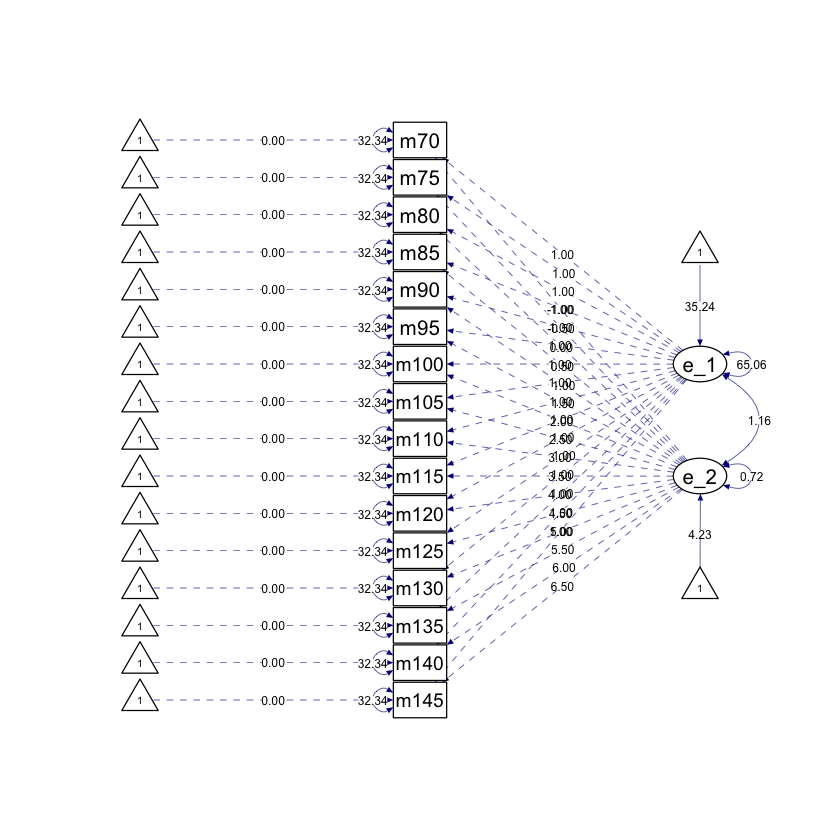

In [12]:
lg_math_age_lavaan_fit |>
    semPaths(
        style = "ram",
        whatLabels = "par", edge.label.cex = .6,
        label.prop = 0.9, edge.label.color = "black", rotation = 4,
        equalizeManifests = FALSE, optimizeLatRes = TRUE, node.width = 1.5,
        edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
        shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
        curve = 2, unCol = "#070b8c"
    )